# **Prepare Dataset**

In [ ]:
!pip install -q kaggle

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d "suchintikasarkar/sentiment-analysis-for-mental-health"

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
 90% 10.0M/11.1M [00:01<00:00, 12.5MB/s]
100% 11.1M/11.1M [00:01<00:00, 10.9MB/s]


In [2]:
import zipfile

dataset_zip = zipfile.ZipFile("/content/sentiment-analysis-for-mental-health.zip", "r")
dataset_zip.extractall()
dataset_zip.close()

# **Read and Define Data to Variable**

In [3]:
import pandas as pd
raw_data = pd.read_csv("/content/Combined Data.csv")

# Local computing
# raw_data = pd.read_csv("../data/sentiments.csv")

In [4]:
df = raw_data.dropna()
print("Total data (rows):", len(df), "\n")

df.sample(frac = 1).head()

Total data (rows): 52681 



,Unnamed: 0,statement,status
31309,31309,mostly talk radio.,Normal
20730,20730,Hello guys this is my first time making a post...,Depression
51875,51875,need help with SSRI nausea I was wondering if...,Anxiety
31018,31018,what are they?,Normal
51374,51374,Liking someone I wanna know how other people w...,Personality disorder


In [9]:
# Count the number of occurrences of each class

class_counts = df['status'].value_counts()
class_counts

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [14]:
# Remove imbalance label data

df = df[~df['status'].isin(("Anxiety", "Bipolar", "Stress", "Personality disorder"))]
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652


# **Label Encoding**

In [15]:
classes = df['status'].unique()
print("Total classes/ labels:", len(classes), "\n")
classes

Total classes/ labels: 3 



array(['Normal', 'Depression', 'Suicidal'], dtype=object)

In [16]:
import numpy as np
import pandas as pd

def to_class_num(class_name):
    class_list_num = np.where(classes == class_name)[0][0]
    return class_list_num

def to_class_name(class_num):
    return classes[class_num]

classes_pd = pd.DataFrame({
    "Class Name" : classes,
    "Value" : [to_class_num(class_name) for class_name in classes]
})
display(classes_pd)

,Class Name,Value
0,Normal,0
1,Depression,1
2,Suicidal,2


# **Train-Test Split & Preprocessing Dataset**

In [17]:
from sklearn.model_selection import train_test_split

x_data = df['statement']
y_data = df['status']

x_train, x_test, y_train, y_test = train_test_split(
    x_data.values,
    y_data.values,
    test_size = 0.3,
    random_state = 1000
)
print(len(x_train), len(y_train), len(x_test), len(y_test))

29679 29679 12720 12720


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='UNK', lower = True)
tokenizer.fit_on_texts(x_data.values)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

In [19]:
max_len = max([len(x) for x in x_train_tokenized])
print(max_len)

6300


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_tokenized_padded = pad_sequences(x_train_tokenized, maxlen = max_len)
x_test_tokenized_padded = pad_sequences(x_test_tokenized, maxlen = max_len)

x_train_tokenized_padded[0]

array([  0,   0,   0, ...,   3,   6, 536], dtype=int32)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

54741

# **Defining Device and Transforming Dataset**

In [22]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Device:", device, "\n")

Device: cuda:0 



In [23]:
from torch.utils.data import Dataset

class CustomizedDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.x[idx])
        y = torch.tensor(to_class_num(self.y[idx]))
        return x, y

sample = CustomizedDataset(x_train_tokenized_padded, y_train)
sample[0]

(tensor([  0,   0,   0,  ...,   3,   6, 536], dtype=torch.int32), tensor(1))

# **Batch Data Loading**

In [24]:
from torch.utils.data import DataLoader

batch_size = 24
train_dataloader = DataLoader(CustomizedDataset(x_train_tokenized_padded, y_train), shuffle = True, batch_size = batch_size)
test_dataloader = DataLoader(CustomizedDataset(x_test_tokenized_padded, y_test), shuffle = True, batch_size = batch_size)

train_dataloader

# **Define & Build Model**

In [25]:
import torch.nn as nn

num_lstm = 1
num_hidden = 32
embedding_size = 128

softmax = nn.Softmax(dim=1)

class SentimentAnalysisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, num_hidden, bidirectional = True, num_layers=num_lstm)
        self.linear = nn.Linear(2 * num_hidden * max_len, len(classes))
        self.dropout = nn.Dropout(p=0.35)

    def forward(self, x):
        logits = self.embd(x)
        logits , (h_n, c_n) = self.lstm(logits)
        logits = logits.flatten(start_dim = 1, end_dim=-1)
        logits = self.linear(logits)
        logits = self.dropout(logits)
        probability = softmax(logits)
        return logits, probability

In [26]:
model = SentimentAnalysisModel()
model.train()

SentimentAnalysisModel(
  (embd): Embedding(54741, 128, padding_idx=0)
  (lstm): LSTM(128, 32, bidirectional=True)
  (linear): Linear(in_features=403200, out_features=3, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [27]:
test = x_train_tokenized_padded[0]
test = torch.from_numpy(test[None, :])
print(test.shape)
pred, prob = model(test)
print(pred.shape)

torch.Size([1, 6300])
torch.Size([1, 3])


In [28]:
from tqdm import tqdm
import torch
import torch.nn as nn

cross_entropy = nn.CrossEntropyLoss()   # criterion
model = model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.02, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
epochs = 24

avg_loss = []
avg_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    acc = 0
    loss_acc = 0
    n = 0

    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)

        pred, prob = model(x)

        loss = cross_entropy(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = pred.argmax(axis=1)

        acc += (output == y).sum().item()
        n += y.shape[0]
        loss_acc += loss.item()

    avg_loss.append(loss_acc / len(train_dataloader))
    avg_acc.append(acc / n)
    print('Average Loss     :', loss_acc / len(train_dataloader))
    print('Average Accuracy :', acc / n)

    # scheduler.step()

Epoch 1/24


100%|██████████| 1237/1237 [00:29<00:00, 41.50it/s]


Average Loss     : 2.377253064462612
Average Accuracy : 0.6134640655008592
Epoch 2/24


100%|██████████| 1237/1237 [00:29<00:00, 41.86it/s]


Average Loss     : 0.6861728376911451
Average Accuracy : 0.7167694329323764
Epoch 3/24


100%|██████████| 1237/1237 [00:29<00:00, 42.15it/s]


Average Loss     : 0.5812686426970105
Average Accuracy : 0.7530577175780855
Epoch 4/24


100%|██████████| 1237/1237 [00:29<00:00, 41.37it/s]


Average Loss     : 0.5382980970408324
Average Accuracy : 0.7717241146938913
Epoch 5/24


100%|██████████| 1237/1237 [00:29<00:00, 41.69it/s]


Average Loss     : 0.5049722483178349
Average Accuracy : 0.7817985781192088
Epoch 6/24


100%|██████████| 1237/1237 [00:29<00:00, 41.77it/s]


Average Loss     : 0.48266475661541053
Average Accuracy : 0.7942316115772095
Epoch 7/24


100%|██████████| 1237/1237 [00:29<00:00, 41.53it/s]


Average Loss     : 0.4668160884512367
Average Accuracy : 0.8007345260958927
Epoch 8/24


100%|██████████| 1237/1237 [00:29<00:00, 41.51it/s]


Average Loss     : 0.4508675207943327
Average Accuracy : 0.8071700528993564
Epoch 9/24


100%|██████████| 1237/1237 [00:29<00:00, 41.64it/s]


Average Loss     : 0.43617395459160074
Average Accuracy : 0.8149533340072105
Epoch 10/24


100%|██████████| 1237/1237 [00:29<00:00, 41.65it/s]


Average Loss     : 0.42575719791164107
Average Accuracy : 0.8202432696519425
Epoch 11/24


100%|██████████| 1237/1237 [00:29<00:00, 41.63it/s]


Average Loss     : 0.4183079585276406
Average Accuracy : 0.8218605748172109
Epoch 12/24


100%|██████████| 1237/1237 [00:29<00:00, 41.54it/s]


Average Loss     : 0.405018218530217
Average Accuracy : 0.8265103271673574
Epoch 13/24


100%|██████████| 1237/1237 [00:29<00:00, 41.60it/s]


Average Loss     : 0.39947926780102033
Average Accuracy : 0.8281276323326258
Epoch 14/24


100%|██████████| 1237/1237 [00:29<00:00, 41.58it/s]


Average Loss     : 0.3901267569201939
Average Accuracy : 0.8326089153947236
Epoch 15/24


100%|██████████| 1237/1237 [00:29<00:00, 41.54it/s]


Average Loss     : 0.38002121890612733
Average Accuracy : 0.836011995013309
Epoch 16/24


100%|██████████| 1237/1237 [00:29<00:00, 41.58it/s]


Average Loss     : 0.37333171543038074
Average Accuracy : 0.8376293001785774
Epoch 17/24


100%|██████████| 1237/1237 [00:29<00:00, 41.60it/s]


Average Loss     : 0.3641062347262062
Average Accuracy : 0.8420095016678459
Epoch 18/24


100%|██████████| 1237/1237 [00:29<00:00, 41.50it/s]


Average Loss     : 0.361465956368269
Average Accuracy : 0.8423801341015533
Epoch 19/24


100%|██████████| 1237/1237 [00:29<00:00, 41.46it/s]


Average Loss     : 0.35710124921418046
Average Accuracy : 0.8462212338690657
Epoch 20/24


100%|██████████| 1237/1237 [00:29<00:00, 41.59it/s]


Average Loss     : 0.35046611860599264
Average Accuracy : 0.8481080898952121
Epoch 21/24


100%|██████████| 1237/1237 [00:29<00:00, 41.53it/s]


Average Loss     : 0.345476303879012
Average Accuracy : 0.8532295562518952
Epoch 22/24


100%|██████████| 1237/1237 [00:29<00:00, 41.54it/s]


Average Loss     : 0.3398412304870911
Average Accuracy : 0.8510057616496512
Epoch 23/24


100%|██████████| 1237/1237 [00:29<00:00, 41.58it/s]


Average Loss     : 0.33649316472253593
Average Accuracy : 0.8522524343812123
Epoch 24/24


100%|██████████| 1237/1237 [00:29<00:00, 41.66it/s]

Average Loss     : 0.32741154548422213
Average Accuracy : 0.8584857980390175


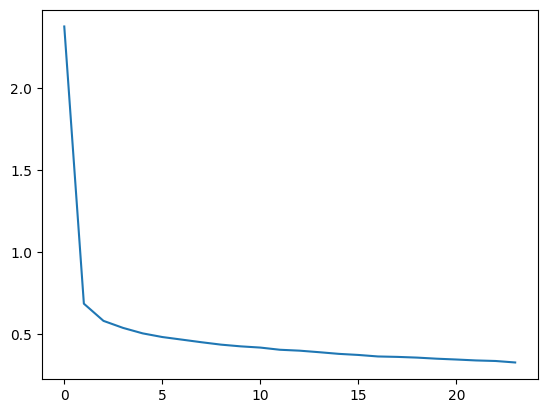

In [29]:
from matplotlib import pyplot as plt

plt.plot(range(len(avg_loss)), avg_loss)

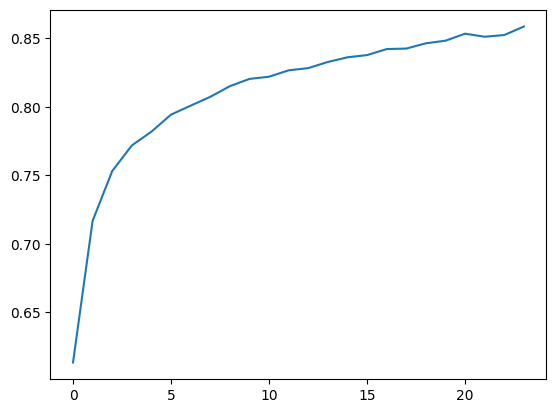

In [30]:
from matplotlib import pyplot as plt

plt.plot(range(len(avg_acc)), avg_acc)

In [31]:
model.eval()

SentimentAnalysisModel(
  (embd): Embedding(54741, 128, padding_idx=0)
  (lstm): LSTM(128, 32, bidirectional=True)
  (linear): Linear(in_features=403200, out_features=3, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [32]:
n = 0
acc = 0
for x, y in tqdm(test_dataloader):
    pred, prob = model(x.to(device))
    output = pred.argmax(axis = 1)
    n += y.shape[0]
    acc += (output == y.to(device)).sum().item()
print()
print('avg test acc:', acc / n)

100%|██████████| 530/530 [00:04<00:00, 125.34it/s]


avg test acc: 0.8038522012578616


In [33]:
# Save entire model

PATH = '/content/sentiment_analysis_model.h5'
torch.save(model, PATH)

In [34]:
# Save configuration file

import json

# Create a dictionary to store all the variables
data = {
    'classes': classes.tolist(),
    'max_len': max_len,
    'vocab_size': vocab_size,
    'tokenizer': tokenizer.to_json()
}

# Save the dictionary to a pickle file
with open('config.json', 'w') as f:
    json.dump(data, f)

# **Predicting**

In [35]:
def predict_sentiment(text):
    input_tensor = torch.from_numpy(pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = max_len))
    pred, prob = model(input_tensor.to(device))
    pred = pred.cpu().detach().numpy().argmax(axis=1).flatten()[0]
    return to_class_name(pred), prob.max().item()

In [41]:
predict_sentiment(input("What's your matter?\n"))

What's your matter?
I feel very stressed from a few days everyone hates me I have not been happy from over a month


('Depression', 0.6082115173339844)

In [ ]:
# im hopeless, need someone here before i kill myself
# I feel very stressed from a few days everyone hates me I have not been happy from over a month
# this is the happiest day of my life, my life is going to be perfect  // 1 by 1: normal, both: suicide, depression??